In [64]:
from natsort import natsorted

## sys
import random
import time
from glob import glob
import json


## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

In [66]:
def dict2tensor(d, fill=None):
    n = len(d.keys())
    k2i = {k:i for i,k in enumerate(natsorted(d.keys()))}
    res = torch.zeros(len(d.keys()), len(d.keys()), device=device)
    for src_node, dst_nodes in d.items():
        for dst_node, distance in dst_nodes.items():
            if fill is not None:
                res[k2i[src_node],k2i[dst_node]] = fill
            else:
                res[k2i[src_node],k2i[dst_node]] = distance
    return res, k2i


def graph2json(G,D,W, initPositions):
    return {
        'nodes': [
            {
                'index':i, 
                'id': n,
                'x': initPositions[i]['x'],
                'y': initPositions[i]['y'],
            } 
            for i, n in enumerate(G.nodes)
        ],
        'edges': [
            {
                'source': e1, 
                'target': e2
            } 
            for e1,e2 in G.edges
        ],
        'weight': W.cpu().numpy().tolist(),
        'graphDistance': D.cpu().numpy().tolist(),
    }

## generate a graph

In [67]:
fns = natsorted(
    glob('_tsne_output/*.json')
    +glob('_neato_sfdp_layouts0/*.dot'),
    key=lambda x:x.split('/')[-1]
)
fns

['_neato_sfdp_layouts0/bipartite_neato.dot',
 '_neato_sfdp_layouts0/bipartite_sfdp.dot',
 '_tsne_output/bipartite_tsne.json',
 '_neato_sfdp_layouts0/block_neato.dot',
 '_neato_sfdp_layouts0/block_sfdp.dot',
 '_tsne_output/block_tsne.json',
 '_neato_sfdp_layouts0/complete_neato.dot',
 '_neato_sfdp_layouts0/complete_sfdp.dot',
 '_tsne_output/complete_tsne.json',
 '_neato_sfdp_layouts0/cube_neato.dot',
 '_neato_sfdp_layouts0/cube_sfdp.dot',
 '_tsne_output/cube_tsne.json',
 '_neato_sfdp_layouts0/cycle_neato.dot',
 '_neato_sfdp_layouts0/cycle_sfdp.dot',
 '_tsne_output/cycle_tsne.json',
 '_neato_sfdp_layouts0/dodecahedron_neato.dot',
 '_neato_sfdp_layouts0/dodecahedron_sfdp.dot',
 '_tsne_output/dodecahedron_tsne.json',
 '_neato_sfdp_layouts0/grid_neato.dot',
 '_neato_sfdp_layouts0/grid_sfdp.dot',
 '_tsne_output/grid_tsne.json',
 '_neato_sfdp_layouts0/nonsymmetric_neato.dot',
 '_neato_sfdp_layouts0/nonsymmetric_sfdp.dot',
 '_tsne_output/nonsymmetric_tsne.json',
 '_neato_sfdp_layouts0/spx_teas

In [70]:

for fn in fns:
    print(' in: ' + fn)
    with open(fn) as f:
        graph = json.load(f)
    
    for d, pos in zip(graph['nodes'], graph['initPositions']):
        d['x'] = pos['x']
        d['y'] = pos['y']
    
    graph['nodes'] = natsorted(graph['nodes'], key=lambda x:x['id'])
    nodes = [n['id'] for n in graph['nodes']]
    edges = [[e['source'], e['target']] for e in graph['edges']]
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    nodeCount = len(G.nodes)
    D, k2i = dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
    Adj,_ = dict2tensor(dict(G.adjacency()), fill=1)
    
    eye = torch.eye(nodeCount, device=device)
    W = 1/(D**2+eye)
    
    js = graph2json(G, D, W, graph['nodes'])
    fnout = fn.split('/')[-1].replace('.dot', '.json')
    if 'neato' in fnout:
        fnout = 'neato_layouts/' + fnout
    elif 'sfdp' in fnout:
        fnout = 'sfdp_layouts/' + fnout
    elif 'tsne' in fnout:
        fnout = 'tsne_layouts/' + fnout
    else:
        raise Exception
        
    with open(fnout, 'w') as f:
        json.dump(js, f, indent=2)
        print('out: neato_sfdp_layouts_json/'+fnout)
        print()
        
        
    if 'neato.dot' in fn:
        init_neato = [[d['x'], d['y']] for d in js['nodes']]
        
    if 'sfdp.dot' in fn:
        init_sfdp = [[d['x'], d['y']] for d in js['nodes']]
    
    if 'tsne.json' in fn:
        init_tsne = [[d['x'], d['y']] for d in js['nodes']]
        
        js['initPosition_neato'] = init_neato
        js['initPosition_sfdp'] = init_sfdp
        js['initPosition_tsne'] = init_tsne
        
        fnout = '_'.join(fnout.split('/')[-1].split('_')[:-1]) + '.json'
        with open(fnout, 'w') as f:
            json.dump(js, f, indent=2)
            print('out: ' + fnout)
        print('-'*20)
        

 in: _neato_sfdp_layouts0/bipartite_neato.dot
out: neato_sfdp_layouts_json/neato_layouts/bipartite_neato.json

 in: _neato_sfdp_layouts0/bipartite_sfdp.dot
out: neato_sfdp_layouts_json/sfdp_layouts/bipartite_sfdp.json

 in: _tsne_output/bipartite_tsne.json
out: neato_sfdp_layouts_json/tsne_layouts/bipartite_tsne.json

out: bipartite.json
--------------------
 in: _neato_sfdp_layouts0/block_neato.dot
out: neato_sfdp_layouts_json/neato_layouts/block_neato.json

 in: _neato_sfdp_layouts0/block_sfdp.dot
out: neato_sfdp_layouts_json/sfdp_layouts/block_sfdp.json

 in: _tsne_output/block_tsne.json
out: neato_sfdp_layouts_json/tsne_layouts/block_tsne.json

out: block.json
--------------------
 in: _neato_sfdp_layouts0/complete_neato.dot
out: neato_sfdp_layouts_json/neato_layouts/complete_neato.json

 in: _neato_sfdp_layouts0/complete_sfdp.dot
out: neato_sfdp_layouts_json/sfdp_layouts/complete_sfdp.json

 in: _tsne_output/complete_tsne.json
out: neato_sfdp_layouts_json/tsne_layouts/complete_tsn

In [72]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))

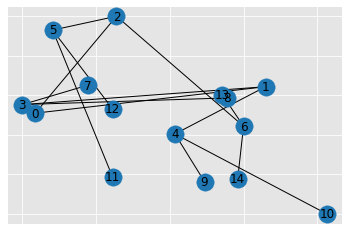

In [77]:
nx.draw_networkx(G, pos=init_tsne)

In [89]:
with open('_tsne_output/tree_tsne.json') as f:
    js = json.load(f)
    nodes = [p['id'] for p in js['nodes']]
    edges = [[e['source'],e['target']] for e in js['edges']]
    pos = {p['id']:[p['x'], p['y']] for p in js['initPositions']}
    G = nx.Graph()


In [91]:
G.add_nodes_from(nodes)
G.add_edges_from(edges)

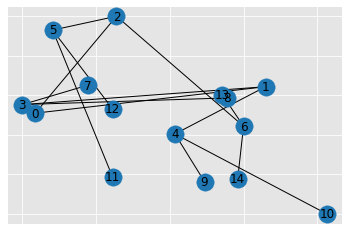

In [92]:
nx.draw_networkx(G, pos=pos)